<a href="https://colab.research.google.com/github/EronDS/Neural-Networks/blob/main/GANs/GenerativeMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Dense,Flatten,Conv2D,Conv2DTranspose,Input,Activation, LeakyReLU, BatchNormalization, Reshape, Dropout, LeakyReLU, UpSampling2D, BatchNormalization
from keras.models import Model,Sequential
from keras.datasets import mnist
import tensorflow.keras.backend as K 
import numpy as np 
from keras.optimizers import RMSprop,Adam
import matplotlib.pyplot as plt 
import PIL
plt.style.use('dark_background')

In [ ]:
(x_train , _) , (x_test , _ ) = mnist.load_data()
(trimgs , _) , (teimgs , _) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.reshape(x_train, [-1, 28 , 28 , 1])
x_test = np.reshape(x_test ,[-1 , 28 , 28 , 1])




In [ ]:
input_shape = [28,28,1]

inputs = Input(shape = input_shape, name = 'encoder_inputs')
filters = [64,128, 128]
z = 0
x = inputs
for filter in filters:
  if filter == 64:
    x = Conv2D(filters = filter, kernel_size= 3,
                    strides =2, padding ='same' , 
                    activation = 'relu')(x)
    x = LeakyReLU()(x)
    z+=1
  if z == 1:
    x = Conv2D(filters = filter, kernel_size= 3,
          strides = 2,padding = 'same',
          activation = 'relu')(x)
    x = LeakyReLU()(x)
    z+=1
  if z==2:
    x = Conv2D(filters = filter, kernel_size= 3,
          strides = 1,padding = 'same',
          activation = 'relu')(x)



x = Conv2D(filters = filter, kernel_size= 3,
          strides = 1,padding = 'same',
          activation = 'relu')(x)


shape = K.int_shape(x)

x = Flatten()(x)

disc_output = Dense(1 ,activation = 'sigmoid' , name = 'output' )(x)

discriminator = Model(inputs, disc_output , name = 'discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)       

In [ ]:
z_dim = 100

latent_inputs = Input(shape = (100,) , name = 'decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1] , shape[2] , shape[3]))(x)

#x = UpSampling2D()(x)
#x = Conv2D(64, kernel_size = 3, strides = 1,
           #padding = 'same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
z = 0
for filter in filters:
  if filter == 64:
    x = UpSampling2D()(x)
    x = Conv2D(filters = filter, kernel_size= 3,
                    strides =1, padding ='same' , 
                    activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    z+=1
  if z == 1:
    x = UpSampling2D()(x)
    x = Conv2D(filters = filter, kernel_size= 3,
                    strides =1, padding ='same' , 
                    activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 1, kernel_size= 3,
                    strides =1, padding ='same' , 
                    activation = 'relu')(x)
    z+=1
  if z==2:
    break
    x = UpSampling2D()(x)
    x = Conv2D(filters = filter, kernel_size= 3,
                    strides =1, padding ='same' , 
                    activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 1, kernel_size= 3,
                    strides =1, padding ='same' , 
                    activation = 'relu')(x)

#x = UpSampling2D()(x)
#x = Conv2DTranspose(filters = filter, kernel_size= 3,
  #        strides = 1,padding = 'same',
 #         activation = 'relu')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)


gen_outputs = Activation('tanh')(x)



generator = Model(latent_inputs, gen_outputs , name = 'generator')
generator.summary()



Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0 

In [ ]:
discriminator.compile(RMSprop(learning_rate = 8e-4),
             loss = 'binary_crossentropy', 
             metrics = ['accuracy'])

discriminator.trainable = False

model_input = Input(shape = [100,] , name = 'model_input')
model_output = discriminator(generator(model_input))

model = Model(model_input,model_output)

model.compile(optimizer = RMSprop(learning_rate = 8e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


In [ ]:
def train_discriminator(x_train, batch_size):
  valid = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))
 

  idx = np.random.randint(0, x_train.shape[0], batch_size)
  true_imgs = x_train[idx]
  discriminator.train_on_batch(true_imgs, valid)

  noise = np.random.normal(0, 1, (batch_size, z_dim))
  gen_imgs = generator.predict(noise)
  discriminator.train_on_batch(gen_imgs, fake)


def train_generator(batch_size):
  valid = np.ones((batch_size,1))
  noise = np.random.normal(0, 1, (batch_size, z_dim))
  model.train_on_batch(noise, valid)


epochs = 10000
batch_size = 64 

for epoch in range(epochs):
  train_discriminator(x_train,batch_size)
  train_generator(batch_size)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
generator (Functional)       (None, 28, 28, 1)         745281    
_________________________________________________________________
discriminator (Functional)   (None, 1)                 449793    
Total params: 1,195,074
Trainable params: 745,025
Non-trainable params: 450,049
_________________________________________________________________


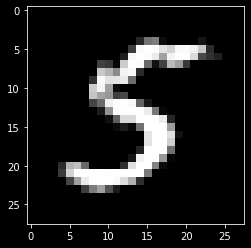

In [ ]:
noise = np.random.normal(0,1, (1,100))
gen_imgs = generator.predict(noise)
gen_imgs = gen_imgs.reshape([28,28,1])
plt.imshow(gen_imgs[:,:,0], cmap = 'gray')

##Generated Images

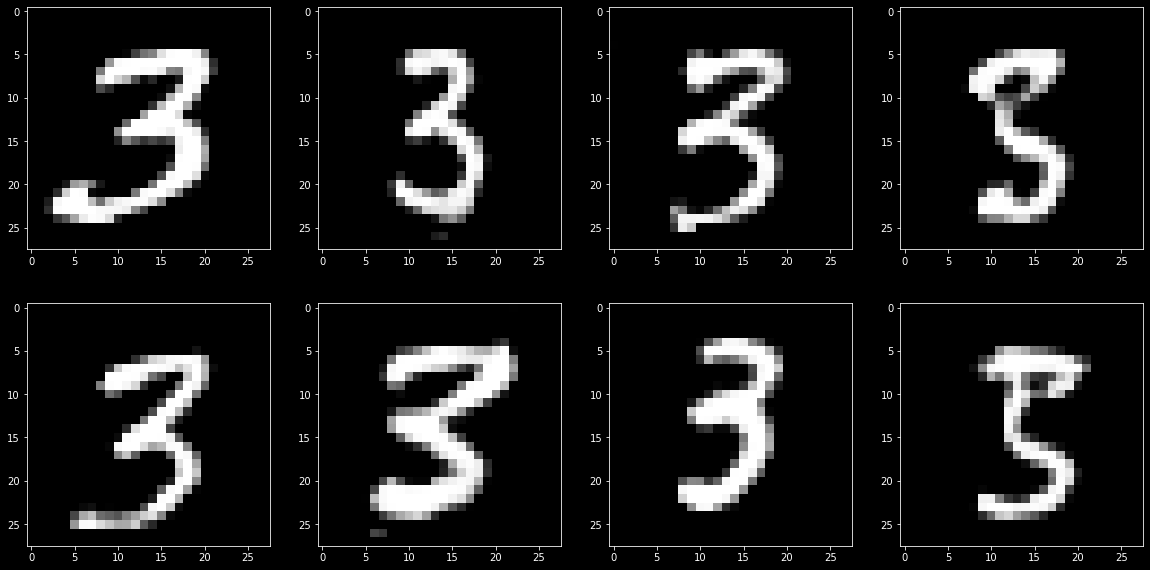

In [ ]:
plt.figure(figsize = (20,10))

for i in range(1,9):
  plt.subplot(2,4,i)
  noise = np.random.normal(0,1, (1,100))
  gen_imgs = generator.predict(noise)
  gen_imgs = gen_imgs.reshape([28,28,1])
  plt.imshow(gen_imgs[:,:,0], cmap = 'gray')
